# AI for Transportation | Recitation 3: Multimodal Machine Learning for Transit Data  

In this recitation, we examine how **multimodal machine learning** can be applied to the public transportation domain. Our aim is to see how modern models handle very different types of input, **text** and **video**, to produce actionable insights for transit operations.  

We will focus on two case studies:  

1. **Text Analysis:** Applying a BERT-based language model to analyze transit agency tweets, extracting categories and identifying themes related to service quality and disruptions.  
2. **Video Analysis:** Using semantic segmentation on station footage to estimate passenger density, providing a proxy for crowding and flow management.  

By working through these examples, you will learn how to build **end-to-end inference pipelines** for both language and vision data, develop intuition about their strengths and limitations, and reflect on how such approaches could be extended in practice and research to improve transit systems.  

# Section 1: Using BERT on Transit Tweets  

In this section, we will apply different *flavours* of the Bidirectional encoder representations from transformers (BERT) model, including **MetRoBERTa**, a fine-tuned model for transit data, to analyze a collection of transit agency tweets. Our goal is to extract three key aspects from the text using separate pretrained models:  

1. **Sentiment** - whether the message conveys a positive, neutral, or negative tone.  
2. **Irony** - whether the message includes sarcasm or irony.  
3. **Transit topics** - the main subject area of the tweet, based on a topical classification model trained for this task.  

The workflow will follow a structure similar to previous recitations:  
- First, we will import the Python libraries needed for natural language processing.  
- Next, we will load both the dataset of tweets and the pretrained models (from Hugging Face and our own source).  
- Finally, we will run inference with these models to generate predictions and begin exploring what insights can be derived from social media data in a transit context.

In [1]:
# --- Imports ---
import csv
import datetime as dt
import re
import string
import urllib.request
from collections import Counter
from pathlib import Path
from typing import (
    Tuple,
    List,
    Callable,
    Iterable,
    Optional,
    Dict,
)

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from wordcloud import WordCloud, STOPWORDS
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
)
from nltk.tokenize import TweetTokenizer

# Choose between CPU and GPU for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


If you see "Using device: cpu", we **recommend switching your runtime to use a T4 GPU**. Google Colab offers these for free up to a certain monthly limit. For setup guidance, see the [Colab GPU documentation](https://cloud.google.com/colab/docs/default-runtimes-with-gpus#enable).

## Data Loading

First, download the text data we prepared: A sample of tweets directed at various accounts managed by the *Washington Metropolitan Area Transit Authority (WMATA)* in Washington, DC, USA from late 2024 in a folder called `data`:

In [2]:
# Download CSV dataset from GDrive
!gdown 1xrhZ0w4dZQr7Kposiw_Ph2qT4pP53o54 -O data/

Downloading...
From: https://drive.google.com/uc?id=1xrhZ0w4dZQr7Kposiw_Ph2qT4pP53o54
To: /Users/joemartis/Downloads/data/twitter_data_2024_sample_v2.csv
100%|██████████████████████████████████████| 3.26M/3.26M [00:00<00:00, 9.33MB/s]


Now, let's load and display the first few tweets in the dataset:

In [3]:
tweets_path = "./data/twitter_data_2024_sample_v2.csv"
tweets = pd.read_csv(tweets_path, index_col='Unnamed: 0').reset_index(drop=True)
tweets.head(2)

,author_id,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,text,geo,name,...,quote_count,reply_count,retweet_count,media_keys,mentions,annotations,hashtags,poll_ids,media_source_tweet_id,cashtags
0,4.517723e+07,1853836115129856173,2024-11-05 16:25:47,['1853836115129856173'],1853836115129856173,0,en,see this @ANC1B 01 Commissioner @larryhanderha...,NaN,Scott Roberts,...,0,0,0,"['3_1853835424965222401', '3_18538360564596080...","[{'end': 15, 'id': '1244150522', 'start': 9, '...","[{'end': 66, 'normalized_text': 'BetterBus', '...","[{'end': 67, 'start': 57, 'tag': 'BetterBus'},...",NaN,NaN,NaN
1,1.417512e+18,1833666466312327211,2024-09-11 00:43:01,['1833667530692481329'],1833667530692481329,971158437571825665,en,@wmataGM dc metro is best metro. now let’s hav...,NaN,Build more homes,...,0,0,0,NaN,"[{'end': 8, 'id': '971158437571825665', 'start...","[{'end': 16, 'normalized_text': 'metro', 'prob...",NaN,NaN,NaN,NaN


In [4]:
# Inspect the size of the provided dataset
tweets.shape

(5000, 31)

As you can see, these tweeets contain valuable information about customer feedback and public opinion of the Washington Metro, but it is in unstructured form and time consuming to process manually.

## Model Loading

To help us automatically analyze these tweets, we will now load three models based on RoBERTa, a natural langauge processing (NLP) model developed by Meta AI in 2019. It is a masked language model trained on a trained on millions of tweets for tasks such as topic classification, sentiment analysis, and more.

*   The first two models, trained to detect sentiment and irony, are open-source models we are loading from HuggingFace, an online model repository. Documentation is available at: [twitter-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) and [twitter-roberta-base-irony](https://huggingface.co/cardiffnlp/twitter-roberta-base-irony)
*   The third model is a topic model, MetRoBERTa, which was developed in-house at the MIT Transit Lab and trained on customer feedback data to classify the topics of transit-related tweets and complaints. For more information on how the model works, you can refer to [Leong et al.'s](https://journals.sagepub.com/doi/abs/10.1177/03611981231225655) paper.

Below are a few helper functions to download the models:

In [5]:
# ---------- 2) Model loading ----------
# This function loads models from Hugging Face, an online repository
def load_hf_model(model_id: str) -> Tuple[AutoTokenizer, AutoModelForSequenceClassification, List[str]]:
    """
    Load a Hugging Face model by its model_id (from the Hub) together with its tokenizer
    and label list. Falls back to generic 'LABEL_i' names if id2label is not set in config.

    Returns
    -------
    tuple
        (tokenizer, model, labels)
    """
    tok = AutoTokenizer.from_pretrained(model_id)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_id)
    id2label = getattr(mdl.config, "id2label", None)
    if id2label and isinstance(id2label, dict):
        labels = [id2label[i] for i in sorted(id2label.keys(), key=int)]
    else:
        labels = [f"LABEL_{i}" for i in range(mdl.config.num_labels)]
    return tok, mdl, labels


# Custom labels for topic model
id2label = {
    'LABEL_0': 'Announcements/Signage',
    'LABEL_1': 'Bunching',
    'LABEL_2': 'Cleanliness',
    'LABEL_3': 'Crime/Harassment/Security',
    'LABEL_4': 'Crowding',
    'LABEL_5': 'Customer Service',
    'LABEL_6': 'Elevator/Escalator',
    'LABEL_7': 'Facilities Maintence',
    'LABEL_8': 'General',
    'LABEL_9': 'Graffiti',
    'LABEL_10': 'Heating/Cooling',
    'LABEL_11': 'Homeless',
    'LABEL_12': 'Injury/Claims',
    'LABEL_13': 'Schedules/Delays',
    'LABEL_14': 'Smoking',
    'LABEL_15': 'Stopping',
    'LABEL_16': 'Transit Tracking App',
    'LABEL_17': 'Vehicle Maintenance',
    'LABEL_18': 'Vehicle Operations',
    'LABEL_19': 'Fares'
}

label2id = {label: i for i, label in id2label.items()}


# This function loads a custom model developed at MIT for transit-specific topic classification
def load_local_model(folder_path: str | Path) -> Tuple[AutoTokenizer, AutoModelForSequenceClassification, List[str]]:
    """
    Load a locally saved HF classifier (config + tokenizer + weights) and return:
      (tokenizer, model, labels_list)

    labels_list is built from config.id2label if present; otherwise uses LABEL_{i}.
    """
    folder_path = str(folder_path)

    # Load config/tokenizer/model from local dir
    config = AutoConfig.from_pretrained(folder_path)
    tokenizer = AutoTokenizer.from_pretrained(folder_path, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(folder_path)

    # Build labels list robustly
    labels: List[str]
    if isinstance(id2label, dict) and len(id2label) == model.config.num_labels:
        def to_int(k):
            try:
                return int(k)
            except Exception:
                return k
        ordered_keys = sorted(id2label.keys(), key=to_int)
        try:
            labels = [id2label[str(i)] if str(i) in id2label else id2label[i] for i in range(model.config.num_labels)]
        except Exception:
            labels = [id2label[k] for k in ordered_keys]
    else:
        labels = [f"LABEL_{i}" for i in range(model.config.num_labels)]

    return tokenizer, model, labels

Downloading the custom MetRoBERTa model-related files:

In [6]:
!mkdir topical-bert
LOCAL_DIR = "./topical-bert/"

# --remaining-ok keeps existing files if you re-run
!gdown 1Yx39DabIpbpDIQPajAub6WIAo2_2HQwf -O "{LOCAL_DIR}/config.json"  # config.json
!gdown 1r7X3CZrZPTBeLAe8DHNmIpqYn2FyExMd -O "{LOCAL_DIR}/model.safetensors"  # model.safetensors
!gdown 1_2Jwxa-nzHUBHUA5jZW7rQfTyCnp2T-w -O "{LOCAL_DIR}/tokenizer.json"  # tokenizer.json

mkdir: topical-bert: File exists
Downloading...
From: https://drive.google.com/uc?id=1Yx39DabIpbpDIQPajAub6WIAo2_2HQwf
To: /Users/joemartis/Downloads/topical-bert/config.json
100%|██████████████████████████████████████| 1.54k/1.54k [00:00<00:00, 2.56MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1r7X3CZrZPTBeLAe8DHNmIpqYn2FyExMd
From (redirected): https://drive.google.com/uc?id=1r7X3CZrZPTBeLAe8DHNmIpqYn2FyExMd&confirm=t&uuid=fa2f8e72-bfd5-4ab1-b0cf-36f0b7cb7eef
To: /Users/joemartis/Downloads/topical-bert/model.safetensors
100%|████████████████████████████████████████| 499M/499M [00:36<00:00, 13.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_2Jwxa-nzHUBHUA5jZW7rQfTyCnp2T-w
To: /Users/joemartis/Downloads/topical-bert/tokenizer.json
100%|██████████████████████████████████████| 3.56M/3.56M [00:00<00:00, 10.9MB/s]


Now we load all three models into memory:

In [7]:
# Load models once
sentiment_bundle = load_hf_model("cardiffnlp/twitter-roberta-base-sentiment-latest")
irony_bundle = load_hf_model("cardiffnlp/twitter-roberta-base-irony")
local_bundle = load_local_model(LOCAL_DIR)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Inference

Next, we can already start using the models to infer the sentiment, irony, and the transit-specific topic of the tweets. Before we start the inference, we need to clean and tokenize the data to remove as noise such as mentions of other people and special characters:

In [8]:
def clean_text_twitter(df):
    s = df['text'].astype(str)

    # Normalize: strip zero-width and control chars, collapse newlines/spaces
    # Removes common invisibles (ZWSP, ZWNJ, NBSP variants) that can break regex matches.
    s = (s
         .str.replace(r'[\u200B-\u200D\u2060\uFEFF]', '', regex=True)  # zero-widths
         .str.replace(r'\s+', ' ', regex=True)
         .str.strip()
         .str.lower())

    # Remove HTML entities for quotes/apostrophes, plus raw quotes/newlines
    s = s.str.replace(r"&#39;|&#34;|&quot;|'|\n", "", regex=True)

    # Remove Twitter-specific markup (mentions, hashtags, RT markers, t.co links, leading <br>/&nbsp;)
    # (?i) → case-insensitive; (?<!\w)@\w+ prevents matching emails like someone@domain
    s = s.str.replace(r'(?i)(?<!\w)@\w+', ' ', regex=True)               # mentions
    s = s.str.replace(r'(?i)(?<!\w)#\w+', ' ', regex=True)               # hashtags
    s = s.str.replace(r'(?i)\brt\b', ' ', regex=True)                    # RT tag (after lowercasing)
    s = s.str.replace(r'https?://t\.co/\w+', ' ', regex=True)            # t.co links
    s = s.str.replace(r'^(?:&nbsp;|<br>)+', ' ', regex=True)             # stray HTML at start

    # Remove punctuation/symbols but keep word chars and whitespace
    s = s.str.replace(r'[^\w\s]+', ' ', regex=True)

    # Decode common HTML &amp; → and
    s = s.str.replace(r'\bamp\b', 'and', regex=True)

    # Remove remaining non-alphanumeric except whitespace (belt-and-suspenders)
    s = s.str.replace(r'[^a-z0-9\s]', '', regex=True)

    # Collapse whitespace again
    s = s.str.replace(r'\s+', ' ', regex=True).str.strip()

    # Assign back
    df = df.copy()
    df['text_cleaned'] = s

    # Keep tweets with at least 10 words
    df = df[df['text_cleaned'].str.split().str.len() >= 10].copy()

    # Tokenize
    tokenizer = TweetTokenizer()
    df['text_tokenized'] = df['text_cleaned'].apply(tokenizer.tokenize)

    return df.dropna(subset=['text_cleaned'])

tweets = clean_text_twitter(tweets)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
# ---------- 3) Inference ----------
def run_model_batch(
    model: AutoModelForSequenceClassification,
    tokenizer: AutoTokenizer,
    texts: List[str],
    batch_size: int = 32,
    device: torch.device | None = None
) -> np.ndarray:
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)
    model.eval()

    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            all_probs.append(probs)
    return np.vstack(all_probs) if all_probs else np.empty((0, model.config.num_labels))

# --------- label post-processing ----------
def postprocess_sentiment(probs: np.ndarray, labels: List[str], margin: float = 0.25) -> List[str]:
    """
    Neutral-on-uncertain rule for Cardiff sentiment (3 classes).
    Assumes labels contain 'Negative', 'Neutral', 'Positive' or compatible order in id2label.
    """
    out = []
    for p in probs:
        order = np.argsort(p)
        top, second = order[-1], order[-2] if p.size >= 2 else None
        if second is not None and p[top] - p[second] < margin and len(labels) >= 3:
            # Try to find exact 'Neutral', else fallback to index 1 (Cardiff uses id2label[1] = Neutral)
            neutral_idx = None
            for i, name in enumerate(labels):
                if name.lower() == "neutral":
                    neutral_idx = i
                    break
            neutral_idx = 1 if neutral_idx is None and len(labels) > 1 else (neutral_idx or 1)
            out.append(labels[neutral_idx])
        else:
            out.append(labels[top])
    return out


def postprocess_argmax(probs: np.ndarray, labels: List[str]) -> List[str]:
    return [labels[int(np.argmax(p))] for p in probs]

# --------- utils ----------
def preprocess_tweet(text: str) -> str:
    toks = []
    for t in str(text).split():
        if t.startswith('@') and len(t) > 1:
            toks.append('@user')
        elif t.startswith('http'):
            toks.append('http')
        else:
            toks.append(t)
    return " ".join(toks)[:512]


def annotate_df(
    df: pd.DataFrame,
    text_column: str,
    model_bundle: Tuple[AutoTokenizer, AutoModelForSequenceClassification, List[str]],
    label_fn: Callable[[np.ndarray, List[str]], List[str]],
    prefix: str,
    batch_size: int = 32,
) -> pd.DataFrame:
    tokenizer, model, labels = model_bundle
    texts = [preprocess_tweet(t) for t in df[text_column].astype(str).tolist()]
    probs = run_model_batch(model, tokenizer, texts, batch_size=batch_size)
    labels_out = label_fn(probs, labels)
    df[f"{prefix}_label"] = labels_out
    df[f"{prefix}_scores"] = [p.tolist() for p in probs]
    return df

Now, we will call of the 3 RoBERTa-based NLP models to add 3 more fields to the tweets dataset: sentiment, irony, and topic. Each inference returns two fields: the most likely outcome, and the probabilities of all 3 outcomes according to the model. *Note that the following code will take longer to run, since we need to do neural network forward-passes.*

In [10]:
# Infer topics
tweets = annotate_df(
      tweets,
      text_column="text_cleaned",
      model_bundle=local_bundle,
      label_fn=postprocess_argmax,
      prefix="topic",
      batch_size=32,
)

# Map topic label
# tweets['topic_label']= tweets['topic_label'].map(id2label)

# Infer sentiment
tweets = annotate_df(
      tweets,
      text_column="text_cleaned",
      model_bundle=sentiment_bundle,
      label_fn=lambda probs, labels: postprocess_sentiment(probs, labels, margin=0.25),
      prefix="sentiment",
      batch_size=64,
)

# Infer irony
tweets = annotate_df(
      tweets,
      text_column="text_cleaned",
      model_bundle=irony_bundle,
      label_fn=postprocess_argmax,
      prefix="irony",
      batch_size=64,
)

Let's pause for a second and consider the following (original text) tweet:

In [11]:
tweets['text'][1]

'@wmataGM dc metro is best metro. now let’s have the doors open faster and work towards reducing the number of holdups.'

This exemplifies why we need to explore irony. Tweets, and online social media content in general, is often sarcastic. Thus, if a tweet is detected as being both ironic and positive, then we flip the sentiment to *negative* to reflect the true meaning of what a user attempted to convey.

In [12]:
# Logic to flip sentiment based on irony
def final_sentiment(row):
    sentiment_scores = row['sentiment_scores']
    irony_scores = row['irony_scores']

    # if there is a high confidence of negative, then return negative
    if sentiment_scores[0] >= 0.6:
        return 'negative'
    # if there is a high confidence of positive and there is irony detected, then return negative (otherwise, return positive)
    elif sentiment_scores[2] >= 0.6:
        if irony_scores[1] >= 0.95:
            return 'negative'
        else:
            return 'positive'
    # otherwise, return neutral
    else:
        return 'neutral'

# Apply to tweets
tweets['final_sentiment_label'] = tweets.apply(final_sentiment, axis=1)

Let's see a sample of what the inference results look like:

In [13]:
tweets[['text', 'topic_label', 'topic_scores', 'sentiment_label',
       'sentiment_scores', 'irony_label', 'irony_scores','final_sentiment_label']].head()

,text,topic_label,topic_scores,sentiment_label,sentiment_scores,irony_label,irony_scores,final_sentiment_label
0,see this @ANC1B 01 Commissioner @larryhanderha...,Transit Tracking App,"[0.0022300591226667166, 0.00012162439088569954...",neutral,"[0.02282305434346199, 0.925845742225647, 0.051...",non_irony,"[0.5429704189300537, 0.45702964067459106]",neutral
1,@wmataGM dc metro is best metro. now let’s hav...,Crime/Harassment/Security,"[0.0019287390168756247, 0.002896605059504509, ...",positive,"[0.019932279363274574, 0.1098904013633728, 0.8...",irony,"[0.10048535466194153, 0.8995146155357361]",positive
2,@who_shot_jgr @wmataGM @Dulles_Airport @wmata ...,Transit Tracking App,"[0.008931996300816536, 0.0006426672916859388, ...",neutral,"[0.5185652375221252, 0.36059659719467163, 0.12...",non_irony,"[0.7155792713165283, 0.2844206988811493]",neutral
3,@Ashmew8 @wmataGM @wmata I heard they can’t ha...,Transit Tracking App,"[9.953456174116582e-05, 5.9517780755413696e-05...",neutral,"[0.2352408617734909, 0.5589526295661926, 0.205...",non_irony,"[0.9170524477958679, 0.08294752240180969]",neutral
4,@wmataGM @wmata @Metrorailinfo @Metrobusinfo @...,Homeless,"[0.002049762289971113, 0.01025516726076603, 0....",negative,"[0.6134732961654663, 0.3577166199684143, 0.028...",irony,"[0.06846977025270462, 0.9315302968025208]",negative


## Analysis

### Tweet Volumes
Now that we have categorized some of that data, let's extract some analytical insights! First, let's look at how many tweets of selected topics occured over time. To that end, we will select a subset of the topic labels and plot a *smoothed* temporal progression of the respective tweets, i.e. we are using a *rolling average* to make trends clearer to identify.

In [14]:
tweets['topic_label'].unique()

array(['Transit Tracking App', 'Crime/Harassment/Security', 'Homeless',
       'Crowding', 'Announcements/Signage', 'Facilities Maintence',
       'General', 'Schedules/Delays', 'Injury/Claims', 'Smoking',
       'Vehicle Operations', 'Graffiti', 'Heating/Cooling', 'Fares',
       'Stopping', 'Vehicle Maintenance', 'Customer Service',
       'Elevator/Escalator', 'Bunching', 'Cleanliness'], dtype=object)

In [15]:
#@title Plotting Code

def prepare_tweets_timezone(
    data_twitter: pd.DataFrame,
    created_col: str = "created_at",
    tz: str = "US/Eastern",
) -> pd.DataFrame:
    """
    Return a copy of `data_twitter` with a tz-aware datetime column and helper fields.
    - Robustly parses datetimes and converts everything to the given timezone.
    - Adds columns: 'created_local' (tz-aware), 'date' (naive date at local midnight), 'hour' (local hour).
    """
    if created_col not in data_twitter.columns:
        raise KeyError(f"Column '{created_col}' not found in DataFrame.")

    out = data_twitter.copy()
    s = pd.to_datetime(out[created_col], utc=True, errors="coerce")
    out["created_local"] = s.dt.tz_convert(tz)                  # tz-aware
    out["date"] = out["created_local"].dt.tz_localize(None).dt.floor("D")  # naive daily timestamp
    out["hour"] = out["created_local"].dt.hour
    return out


RC_PARAMS_DICT = {
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "axes.labelsize": 14,
    "axes.labelweight": "bold",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
}


def plot_topic_volume(
    df: pd.DataFrame,
    topics: Iterable[str],
    *,
    topic_col: str = "topic_label",
    date_col: str = "date",
    created_local_col: str = "created_local",
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Plot smoothed daily tweet volumes for selected topics.
    Internal defaults control appearance (window, figsize, rcParams, etc.).
    """

    window = 7
    center = True
    figsize = (12, 6)

    title = "Daily Smoothed Tweet Volume by Topic"
    x_label = "Date"
    y_label = "Tweet Volume"
    legend_title = "Topic"
    rotate_xticks = 45
    grid = True

    if topic_col not in df.columns:
        raise KeyError(f"Column '{topic_col}' not found in DataFrame.")
    if date_col not in df.columns and created_local_col not in df.columns:
        raise KeyError(
            f"Provide either '{date_col}' (daily/naive) or '{created_local_col}' (tz-aware) in the DataFrame."
        )

    topics = list(topics)
    if not topics:
        raise ValueError("`topics` must contain at least one topic string.")

    work = df.copy()
    if date_col not in work.columns:
        work[date_col] = work[created_local_col].dt.tz_localize(None).dt.floor("D")

    # Filter topics
    work = work[work[topic_col].isin(topics)]
    if work.empty:
        with plt.rc_context(RC_PARAMS_DICT):
            fig, ax = plt.subplots(figsize=figsize)
            ax.set_title(title)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            if grid:
                ax.grid(True)
        return fig, ax, pd.DataFrame()

    # Daily counts pivot
    daily = (
        work.groupby([date_col, topic_col])
        .size()
        .rename("count")
        .reset_index()
        .pivot(index=date_col, columns=topic_col, values="count")
        .fillna(0)
        .sort_index()
    )

    # Ensure continuous daily index
    full_idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
    daily = daily.reindex(full_idx).fillna(0)

    # Smoothed rolling
    smoothed = daily.rolling(window=window, min_periods=1, center=center).mean()

    # Plot
    with plt.rc_context(RC_PARAMS_DICT):
        fig, ax = plt.subplots(figsize=figsize)
        for col in smoothed.columns:
            ax.plot(smoothed.index, smoothed[col], label=col)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
        ax.legend(title=legend_title, title_fontsize=16)
        if grid:
            ax.grid(True)
        if rotate_xticks:
            for tick in ax.get_xticklabels():
                tick.set_rotation(rotate_xticks)
        fig.tight_layout()

    return fig, ax, smoothed


def plot_sentiment_heatmap(
    df: pd.DataFrame,
    topic_col: str = "topic_label",
    sentiment_col: str = "final_sentiment_label",
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:
    """
    Plot a heatmap of sentiment distribution (%) by topic.
    Uses fixed rcParams and styling consistent with other plots.
    Returns (fig, ax, ct_percent).
    """

    figsize = (8, 6)

    title = "Sentiment Distribution by Topic (%)"
    x_label = "Sentiment"
    y_label = "Topic"

    if topic_col not in df.columns:
        raise KeyError(f"Column '{topic_col}' not found in DataFrame.")
    if sentiment_col not in df.columns:
        raise KeyError(f"Column '{sentiment_col}' not found in DataFrame.")

    # Crosstab and percentages
    ct = pd.crosstab(df[topic_col], df[sentiment_col])
    ct_percent = ct.div(ct.sum(axis=1), axis=0) * 100

    # Plot
    with plt.rc_context(RC_PARAMS_DICT):
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(
            ct_percent,
            annot=True, fmt=".1f", cmap="Blues", cbar=True,
            vmin=0, vmax=100,
            ax=ax
        )
        ax.set_title(title)
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        fig.tight_layout()

    return fig, ax, ct_percent


def plot_topic_wordclouds(
    df: pd.DataFrame,
    selected_topics: Iterable[str],
    *,
    topic_col: str = "topic_label",
    tokens_col: str = "text_tokenized",
) -> List[Tuple[str, plt.Figure, plt.Axes, Counter]]:
    """
    Create word clouds for each topic in `selected_topics`.
    Uses fixed rcParams consistent with other plots.
    Returns a list of (topic, fig, ax, freqs).
    """

    figsize = (10, 6)
    title_prefix = "Topic"

    if topic_col not in df.columns:
        raise KeyError(f"Column '{topic_col}' not found in DataFrame.")
    if tokens_col not in df.columns:
        raise KeyError(f"Column '{tokens_col}' not found in DataFrame.")

    # Stopwords & normalization
    _punct_or_sym = re.compile(r'^[\W_]+$')
    extra_stops = {"rt", "amp", "https", "http", "co", "…", "metro", "train",
                   "bus", "minutes", "line", "s", "t"}
    stops = set(STOPWORDS) | extra_stops

    def norm(tok: str) -> str:
        if not isinstance(tok, str):
            return ""
        tok = tok.lower().strip()
        if tok.startswith("@"):       # mentions
            return ""
        if tok.startswith("http"):    # urls
            return ""
        if _punct_or_sym.match(tok):  # pure punctuation/symbols
            return ""
        if tok.isnumeric():           # pure numbers
            return ""
        return tok

    results: List[Tuple[str, plt.Figure, plt.Axes, Counter]] = []

    for topic in selected_topics:
        rows = df.loc[df[topic_col] == topic, tokens_col].dropna()

        tokens = (norm(t) for row in rows for t in row)
        tokens = [t for t in tokens if t and t not in stops]
        freqs = Counter(tokens)

        if not freqs:
            print(f"[warn] no tokens for topic '{topic}', skipping")
            continue

        wc = WordCloud(
            width=1200, height=800, background_color="white", max_words=300
        ).generate_from_frequencies(freqs)

        with plt.rc_context(RC_PARAMS_DICT):
            fig, ax = plt.subplots(figsize=figsize)
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f"{title_prefix}: {topic}")
            fig.tight_layout()

        results.append((topic, fig, ax, freqs))

    return results

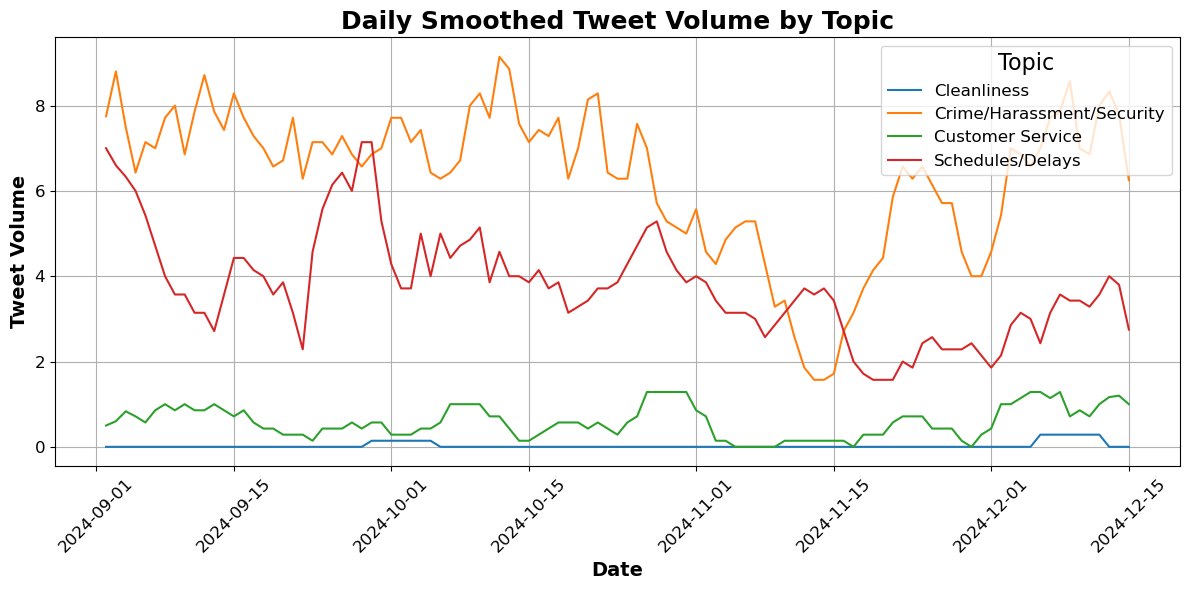

In [16]:
# 1) Prepare (robust datetime parsing + timezone conversion)
tweets_prepped = prepare_tweets_timezone(tweets, created_col="created_at", tz="US/Eastern")

# 3) Plot
selected_topics = [
    "Schedules/Delays",
    "Customer Service",
    "Cleanliness",
    "Crime/Harassment/Security",
]

fig, ax, smoothed_df = plot_topic_volume(
    tweets_prepped,
    topics=selected_topics,
)

You can notice the daily variability of the tweets, as well as an overall reduction in complaints about the Schedules/Delays. Interesting is also the dip in Crime/Herassment/Security-related posts at the beginning of November. We here present you with a very small sample of the actual tweets throughout this 1-year period, thus trends are limited in their expressivity. However, with the full dataset, Leong et al. were able to generate the following visualization, building on the same methodology as we did:

<img src="https://drive.google.com/uc?export=view&id=18IKLV8lDlNqJJ5AwFMfwxRoe_R7ufN02" width="500">

As one can see, after the implementation of the Clean Sweep program (which you can read more about [here on page 105](https://wmata.com/about/board/meetings/board-pdfs/upload/3C-Customer-Service-Excellence-Initiatives.pdf)) in 2022, the complaints about Cleanliness reduced noticably. This post-hoc analysis shows, how a continuous evaluation of customer feedback could also be an operational indicator of where and what could cause customer dissatisfaction or service level degradation.

### Sentiment Distribution
Next, let's analyze the distribution of sentiment by topic! We do this by considering the assigned sentiment value for each tweet and group them por topic. Then, the distribution of negative/neutral/positive can provide further insight on what customers are thinking and sharing about the various topics. Notice, how feedback tends to mostly be negative!

In [17]:
fig, ax, ct_percent = plot_sentiment_heatmap(tweets)

Finally, we plot word clouds for selected topics, to visualize how people are talking about them! The bigger a word in the word cloud, the higher its frequency.

In [18]:
selected_topics = ['Schedules/Delays']  # try others like 'Cleanliness'
_ = plot_topic_wordclouds(tweets, selected_topics)

TypeError: asarray() got an unexpected keyword argument 'copy'

# Section 2: Using Image Segmentation on Transit Videos

In [ ]:
# Imports are meant to be independent from above section
# Standard library
import os
import random
from typing import Tuple

# Third-party
import cv2
import numpy as np
import torch
import torchvision
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import ipywidgets as widgets
from IPython.display import display, clear_output
from tqdm import tqdm

# Choose between CPU and GPU for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

If you see "Using device: cpu", we **recommend switching your runtime to use a T4 GPU**. Google Colab offers these for free up to a certain monthly limit. For setup guidance, see the [Colab GPU documentation](https://cloud.google.com/colab/docs/default-runtimes-with-gpus#enable).

## Data Loading

First, download the video data we prepared: A recording of the Wiener Linien U4 station *Karlsplatz* in Vienna, Austria. Store it in a folder called `data`:

In [ ]:
!gdown 1Mj8nESD2IcqoqJen_X9dhJlTn3iaVPe2 -O data/

As a sanity check, let’s display one random frame from the video:

In [ ]:
# ---------- 1) Video helpers ----------
def read_random_frame(video_path: str) -> np.ndarray:
    """
    Open a video and return a single random frame as a BGR uint8 image (OpenCV format).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video: {video_path}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count <= 0:
        cap.release()
        raise ValueError("Video appears to have 0 frames.")

    idx = random.randint(0, frame_count - 1)
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ok, frame_bgr = cap.read()
    cap.release()

    if not ok or frame_bgr is None:
        raise RuntimeError(f"Failed to read frame at index {idx}")

    return frame_bgr

In [ ]:
video_path = "/content/data/vienna_u4_aug_18_2025_no_audio.mov"
random_frame_bgr = read_random_frame(video_path)

# Change the order of color channels (red/blue/green) of the image for plotting
random_frame_rgb = cv2.cvtColor(random_frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(random_frame_rgb)
plt.axis("off")
plt.grid(False)
plt.show()

### What do you notice?
Real-world data is rarely clean. Video quality may be poor, with distortions, color shifts, or occlusions. Models also need to handle crowded and dynamically changing scenes. This is why robust inference is crucial.

## Model Loading
We will use [DeepLabV3-ResNet101](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_resnet101.html#torchvision.models.segmentation.deeplabv3_resnet101), a semantic segmentation model pre-trained on the [PASCAL Visual Object Classes (VOC)](https://docs.ultralytics.com/datasets/detect/voc/) dataset. In this model, class 15 corresponds to *person* (i.e., human pixels) following the PASCAL VOC taxonomy.

Fortunately, for our convenience, this model is already part of the `torchvision` framework and we can access the weights directly through a download utility:

In [ ]:
# ---------- 2) Model loading (reusable) ----------
def load_deeplab_model(device: torch.device) -> torch.nn.Module:
    """
    Load a DeepLabV3-ResNet101 segmentation model with pretrained weights.
    Works with both newer and older torchvision APIs.
    """
    try:
        # Newer torchvision (recommended)
        weights = torchvision.models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
        model = torchvision.models.segmentation.deeplabv3_resnet101(weights=weights)
        preprocess = weights.transforms()  # built-in transforms matching training
    except Exception:
        # Fallback for older torchvision
        model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
        preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device).eval()
    # Attach preprocess so we can reuse it later without global variables
    model._preprocess = preprocess
    return model

In [ ]:
# Load model once; reuse it across frames.
deeplab_model = load_deeplab_model(device)

## Inference

With the data on disk and the model loaded into memory, we can now write the code to perform *inference* on input images. To keep our pipeline clear and reusable, we will first define a set of utility functions.  

The inference process follows these steps:  
* **Input:** Receive an image as a 3-channel array (RGB values between 0 and 255).  
* **Preprocessing:** Normalize colors and reshape the image into the format expected by the model.  
* **Forward pass:** Push the image through the ResNet-based DeepLabV3Plus network to obtain a probability map across all classes in the VOC dataset (20 object classes + 1 background).  
* **Thresholding:** Apply a chosen probability threshold (`prob_threshold`) to create a binary mask. Here, we are interested in class 15 (*person*). Pixels above the threshold are set to 1.  
* **Resizing:** Scale the output mask back to the dimensions of the original image.  

The utilities below encapsulate this pipeline into a single step, making it easy to run inference and enabling further analysis downstream.

In [ ]:
# ---------- 3) Inference utilities ----------
PERSON_CLASS_INDEX = 15  # VOC/COCO-with-VOC-labels 'person' = 15

def predict_person_mask(model: torch.nn.Module,
                        frame_bgr: np.ndarray,
                        device: torch.device,
                        prob_threshold: float = None,
                        resize: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a Blue Green Rred (BGR) frame (H,W,3), return:
      - person_mask_bool: boolean array (H,W) -> True where 'person' is predicted
      - person_prob: float array (H,W) with probability for the 'person' class

    If prob_threshold is None:
        uses argmax over classes (winner-takes-all) to decide person pixels.
    If prob_threshold is set (e.g., 0.5):
        marks pixel as person iff P(person) >= prob_threshold.
    """
    # Convert BGR (OpenCV) -> RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    # Convert NumPy → PIL, because torchvision’s preprocess expects PIL
    frame_pil = Image.fromarray(frame_rgb)

    # Preprocess (to tensor, normalize)
    preprocess = getattr(model, "_preprocess")
    inp = preprocess(frame_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(inp)["out"]  # (1, C, H, W) where C is num classes
        logits = out[0]          # (C, H, W)

    # Softmax to get per-class probabilities
    probs = torch.softmax(logits, dim=0)                # (C, H, W)
    person_prob = probs[PERSON_CLASS_INDEX].cpu().numpy()  # (H, W)

    if prob_threshold is None:
        # Winner-takes-all classification: person if argmax == 15
        pred_labels = torch.argmax(probs, dim=0).cpu().numpy()  # (H, W), int
        person_mask_bool = (pred_labels == PERSON_CLASS_INDEX)
    else:
        # Threshold on person probability
        person_mask_bool = (person_prob >= float(prob_threshold))

    if resize:
        # Resize person_mask and person_prob to the original image size
        frame_height, frame_width, channels = frame_rgb.shape

        person_mask = person_mask_bool.astype(np.float16)
        person_mask_resized = cv2.resize(
            person_mask, (frame_width, frame_height),
            interpolation=cv2.INTER_NEAREST
        )
        person_mask_bool = person_mask_resized.astype(bool)

        person_prob = cv2.resize(
            person_prob, (frame_width, frame_height),
            interpolation=cv2.INTER_NEAREST
        )

    return person_mask_bool, person_prob

Let’s now run inference on one sampled frame. The model outputs a **probability map** of which pixels belong to humans. By applying a confidence threshold, we decide which pixels to keep.  

In [ ]:
probability_threshold = 0.2

# Get boolean mask; use argmax decision by default (set prob_threshold=0.5 if you prefer)
person_mask, person_prob = predict_person_mask(
    deeplab_model, random_frame_bgr, device,
    prob_threshold=probability_threshold, resize=True
)

print(f"Mask dtype: {person_mask.dtype}, shape: {person_mask.shape}, "
        f"person pixels: {int(person_mask.sum())}")

# Display original frame and a transparent overlay of the person probability mask
plt.figure()
plt.imshow(random_frame_rgb)
plt.imshow(person_prob, alpha=0.35)  # probabilty mask overlay
plt.title("Random frame with person probability overlay")
plt.axis("off")
plt.show()

In [ ]:
# Display original frame and a transparent overlay of the boolean person mask
plt.figure()
plt.imshow(random_frame_rgb)
plt.imshow(person_mask, alpha=0.35)  # boolean mask overlay
plt.title("Random frame with a boolean person mask overlay")
plt.axis("off")
plt.show()

To explore the effect of different thresholds, use the interactive tool below:

In [ ]:
#@title Interactive Segmentation Map Explorer Code

# -- 1) Precompute the per-pixel probability once (fast UI)
# Use prob_threshold=None to:
#  - get the argmax (winner-takes-all) mask
#  - and get person_prob (independent of threshold)
argmax_mask, person_prob = predict_person_mask(
    deeplab_model, random_frame_bgr, device, prob_threshold=None, resize=True
)

# Store a display-ready RGB frame
frame_rgb = cv2.cvtColor(random_frame_bgr, cv2.COLOR_BGR2RGB)
H, W = frame_rgb.shape[:2]

# def overlay_mask(frame_rgb: np.ndarray, mask_bool: np.ndarray, alpha=0.35, color=(0,255,0)) -> np.ndarray:
#     """Overlay a boolean mask on an RGB image."""
#     if mask_bool.shape != frame_rgb.shape[:2]:
#         mask_bool = cv2.resize(mask_bool.astype(np.uint8), (frame_rgb.shape[1], frame_rgb.shape[0]),
#                                interpolation=cv2.INTER_NEAREST).astype(bool)
#     overlay = np.zeros_like(frame_rgb, dtype=np.uint8)
#     overlay[mask_bool] = np.array(color, dtype=np.uint8)
#     blended = cv2.addWeighted(frame_rgb, 1.0, overlay, alpha, 0.0)
#     return blended

from matplotlib import cm

def overlay_mask(frame_rgb: np.ndarray,
                 mask_bool: np.ndarray,
                 alpha=0.35,
                 cmap_name="viridis") -> np.ndarray:
    """
    Overlay a boolean mask on an RGB image using a two-color palette
    from the selected matplotlib colormap (background vs mask).
    """
    if mask_bool.shape != frame_rgb.shape[:2]:
        mask_bool = cv2.resize(mask_bool.astype(np.uint8),
                               (frame_rgb.shape[1], frame_rgb.shape[0]),
                               interpolation=cv2.INTER_NEAREST).astype(bool)

    # Pick two colors from the colormap (0.0 and 1.0 endpoints)
    cmap = cm.get_cmap(cmap_name)
    bg_color = (np.array(cmap(0.0)[:3]) * 255).astype(np.uint8)
    mask_color = (np.array(cmap(1.0)[:3]) * 255).astype(np.uint8)

    # Create overlay: mask pixels = mask_color, others = 0
    overlay = np.zeros_like(frame_rgb, dtype=np.uint8)
    overlay[mask_bool] = mask_color

    # Blend only mask pixels over the original frame
    blended = cv2.addWeighted(frame_rgb, 1.0, overlay, alpha, 0.0)

    return blended

def overlay_probability(frame_rgb: np.ndarray, prob: np.ndarray, alpha=0.5, cmap_name="viridis") -> np.ndarray:
    """Overlay a probability heatmap on an RGB image."""
    if prob.shape != frame_rgb.shape[:2]:
        prob = cv2.resize(prob.astype(np.float32), (frame_rgb.shape[1], frame_rgb.shape[0]),
                          interpolation=cv2.INTER_NEAREST)
    prob_clipped = np.clip(prob, 0.0, 1.0)
    cmap = cm.get_cmap(cmap_name)
    heatmap_rgba = cmap(prob_clipped)  # (H,W,4), float in [0,1]
    heatmap_rgb = (heatmap_rgba[..., :3] * 255).astype(np.uint8)

    blended = cv2.addWeighted(frame_rgb, 1.0, heatmap_rgb, alpha, 0.0)
    return blended

# -- 2) Build widgets
mode = widgets.ToggleButtons(
    options=[("Threshold ≥ t", "thresh")], # ("Winner-takes-all", "wta"),
    value="thresh",
    description="Decision:",
)

overlay_mode = widgets.ToggleButtons(
    options=[("Probability map", "prob"), ("Boolean mask", "mask")],
    value="prob",
    description="Overlay:",
)

threshold_slider = widgets.FloatSlider(
    value=0.5, min=0.0, max=1.0, step=0.01,
    description="Threshold:", readout_format=".2f", continuous_update=True
)

alpha_slider = widgets.FloatSlider(
    value=0.4, min=0.0, max=1.0, step=0.05,
    description="Alpha:", readout_format=".2f", continuous_update=True
)

cmap_dropdown = widgets.Dropdown(
    options=["viridis", "plasma", "magma", "inferno", "turbo", "jet"],
    value="viridis",
    description="Colormap:"
)

def update_display(*_):
    clear_output(wait=True)
    display(ui)

    # Choose the boolean mask based on mode
    if mode.value == "wta":
        mask_bool = argmax_mask
    else:
        t = threshold_slider.value
        mask_bool = (person_prob >= float(t))

    # Choose overlay type
    if overlay_mode.value == "prob":
        vis = overlay_probability(frame_rgb, person_prob, alpha=alpha_slider.value, cmap_name=cmap_dropdown.value)
    else:
        vis = overlay_mask(frame_rgb, mask_bool.astype(bool), alpha=alpha_slider.value, cmap_name=cmap_dropdown.value)

    # Draw
    plt.figure(figsize=(8, 6))
    title = f"{'WTA' if mode.value=='wta' else f't≥{threshold_slider.value:.2f}'} • {overlay_mode.label}"
    plt.title(title)
    plt.imshow(vis)
    plt.axis("off")
    plt.show()

# Link callbacks
for w in (mode, overlay_mode, threshold_slider, alpha_slider, cmap_dropdown):
    w.observe(update_display, names="value")

In [ ]:
ui = widgets.VBox([
    widgets.HBox([mode, overlay_mode]),
    widgets.HBox([threshold_slider, alpha_slider, cmap_dropdown]),
])
display(ui)
update_display()

### What do you notice?  
- People closer to the camera are detected more reliably.  
- In distant or distorted regions, probabilities may drop to zero—even when we can clearly see people.  
- This is a classic **transfer learning** limitation: our model was trained on one dataset (Cityscapes) but applied to a new setting (metro station video).  

For many operational questions, however, using this pre-trained model is sufficient without fine-tuning.

## Analyzing the Entire Video
Now that we have an inference pipeline, loading the video, running the model, and visualizing predictions, we can apply it systematically to the entire video we have to our disposition. For that, we will once again define some utility functions to process an entire video stream and save our results for inspection.


Now, that we have a working *inference pipeline*, i.e. we can load data, adapt it to be fed into the model, and then produce an inference on the input, we can now proceed with analyzing the entire video.

In [ ]:
# ---------- 4) Video inference and processing utilities ----------
def process_video_segment(
    video_path: str,
    model: torch.nn.Module,
    device: torch.device,
    start_time_s: float = 0.0,
    end_time_s: float | None = None,
    fps: float | None = None,
    prob_threshold: float | None = 0.2,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Slice a video by [start_time_s, end_time_s), sample frames at `fps` (None = native fps),
    run person segmentation, and return:
      - masks:  (N, H, W) boolean array, same size as original frames
      - frames: (N, H, W, 3) uint8 RGB frames

    Notes
    -----
    - If `fps` > native fps, it falls back to native fps.
    - If `end_time_s` is None, it uses the end of the video.
    - Uses timestamp-based sampling to avoid drift.
    """
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video: {video_path}")

    # Get statistics on the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    native_fps   = cap.get(cv2.CAP_PROP_FPS)
    if total_frames <= 0 or native_fps <= 0:
        cap.release()
        raise ValueError("Video metadata invalid (no frames or FPS <= 0).")

    duration_s = total_frames / native_fps

    # Clamp and sanitize time bounds
    start_time = max(0.0, float(start_time_s))
    end_time   = duration_s if end_time_s is None else float(end_time_s)
    end_time   = max(start_time, min(end_time, duration_s))  # ensure start <= end <= duration
    if end_time <= start_time:
        cap.release()
        return np.empty((0,)), np.empty((0,))  # nothing to process

    # Decide sampling Frames Per Second (FPS)
    if fps is None or fps >= native_fps:
        print("Setting FPS to original video's FPS of:", native_fps)
        target_fps = native_fps
    else:
        target_fps = float(fps)

    # Build target timestamps (left-closed, right-open interval)
    # Ensure at least one sample if the interval is tiny.
    step = 1.0 / target_fps
    if end_time - start_time < 1e-9:
        ts = np.array([start_time], dtype=np.float64)
    else:
        # Use np.arange; include the last timestamp if it lands exactly on the bound
        ts = np.arange(start_time, end_time, step, dtype=np.float64)
        if len(ts) == 0 or (end_time - ts[-1]) >= step * 0.999:
            # ensure we don’t miss the end when the interval is short
            ts = np.append(ts, min(end_time - 1e-6, duration_s))

    # Map timestamps -> nearest frame indices, clamp, and deduplicate while keeping order
    idxs = np.clip(np.round(ts * native_fps).astype(int), 0, total_frames - 1)
    # Keep only those that are unique in order
    unique_mask = np.concatenate(([True], idxs[1:] != idxs[:-1]))
    frame_indices = idxs[unique_mask]
    if len(frame_indices) == 0:
        cap.release()
        return np.empty((0,)), np.empty((0,))

    masks_list: list[np.ndarray] = []
    frames_list: list[np.ndarray] = []

    # Process each selected frame
    for k, fidx in tqdm(list(enumerate(frame_indices))):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(fidx))
        ok, frame_bgr = cap.read()
        if not ok or frame_bgr is None:
            # Skip unreadable frames but continue
            continue

        # Run segmentation (resized back to original size)
        person_mask, _person_prob = predict_person_mask(
            model, frame_bgr, device, prob_threshold=prob_threshold, resize=True
        )

        # Convert frame to RGB for consistency
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        # Collect the generated data
        masks_list.append(person_mask.astype(bool))
        frames_list.append(frame_rgb)

    # Release the video from memory
    cap.release()

    if len(masks_list) == 0:
        return np.empty((0,)), np.empty((0,))

    # Use stacking to put the N generated frames into one array
    masks = np.stack(masks_list, axis=0)             # (N, H, W), bool
    frames_rgb = np.stack(frames_list, axis=0)       # (N, H, W, 3), uint8
    return masks, frames_rgb


def overlay_mask_on_frame(frame_rgb: np.ndarray,
                          mask_bool: np.ndarray,
                          color=(0, 255, 0),
                          alpha: float = 0.35) -> np.ndarray:
    """
    Overlay a boolean mask onto an RGB frame.
    - frame_rgb: (H, W, 3) uint8 in RGB
    - mask_bool: (H, W) boolean
    Returns an RGB uint8 image.
    """
    if mask_bool.dtype != bool:
        mask_bool = mask_bool.astype(bool)

    h, w = frame_rgb.shape[:2]
    if mask_bool.shape != (h, w):
        mask_bool = cv2.resize(mask_bool.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(bool)

    # Create color overlay
    overlay = np.zeros_like(frame_rgb, dtype=np.uint8)
    overlay[mask_bool] = np.array(color, dtype=np.uint8)

    # Alpha blend (keep in RGB space)
    blended = cv2.addWeighted(frame_rgb, 1.0, overlay, alpha, 0.0)
    return blended


def write_video_with_masks(frames_rgb: np.ndarray,
                           masks_bool: np.ndarray,
                           out_path: str = "./person_overlay.mp4",
                           fps: float = 1.0,
                           alpha: float = 0.30,
                           color=(255,228,181)) -> str:
    """
    Write an MP4 video with mask overlays in a bright yellow.
    - frames_rgb: (N, H, W, 3) uint8 in RGB
    - masks_bool: (N, H, W) boolean
    Returns the output path.
    """
    assert len(frames_rgb) == len(masks_bool), "frames and masks must have same length"
    assert frames_rgb.ndim == 4 and frames_rgb.shape[-1] == 3, "frames must be (N,H,W,3) RGB"
    assert frames_rgb.dtype == np.uint8, "frames must be uint8"

    # Create the output folder if it doesn't exist
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    H, W = frames_rgb.shape[1], frames_rgb.shape[2]
    # Use mp4v; if it ever fails in your environment, switch to MJPG + .avi
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, float(fps), (W, H))

    if not writer.isOpened():
        raise RuntimeError("Failed to open video writer. Try a different codec or path (e.g., .avi with MJPG).")

    for i in range(len(frames_rgb)):
        frame_rgb = frames_rgb[i]
        mask = masks_bool[i]

        overlayed_rgb = overlay_mask_on_frame(frame_rgb, mask, color=color, alpha=alpha)
        # OpenCV expects BGR
        overlayed_bgr = cv2.cvtColor(overlayed_rgb, cv2.COLOR_RGB2BGR)
        writer.write(overlayed_bgr)

    writer.release()
    return out_path

### Creating a Sample Video
We first create a short sample video (`person_overlay.mp4`) that overlays detections in yellow. Here, we sample the original video from second 5 to second 10 at the full frame rate (30 Frames Per Second, or FPS in our case) by setting the `fps` parameter to `None`. Finally, we impose a threshold of 0.2 for the Boolean map, meaning that we only consider a pixel to be human if we have more than or equal of 20% probability.

**Important:** For this step, you want to make sure that you have a `GPU` enabled for your workspace. Follow the [intructions here](https://cloud.google.com/colab/docs/default-runtimes-with-gpus#enable) to do so now if you don't (you will have to re-run all of the above *Section 2* code)

In [ ]:
masks, frames_rgb = process_video_segment(
    video_path=video_path,
    model=deeplab_model,
    device=device,
    start_time_s=5.0,
    end_time_s=10.0,
    fps=None,
    prob_threshold=0.2,
)

The following code will write the generated data in a video format to the disk of this virtual instance. You can open the file browser on the left by clicking on this icon:

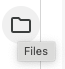

You will see a file called `person_overlay.mp4`, which you can download and play in a mediaplayer of your choice.

In [ ]:
out_video = write_video_with_masks(
    frames_rgb=frames_rgb,       # (N,H,W,3) RGB uint8
    masks_bool=masks,            # (N,H,W) bool
    out_path="./person_overlay.mp4",
    fps=30,                      # FPS of the original video
    alpha=0.35,                  # overlay transparency
    color=(255,228,181)          # overlay color (RGB)
)

Watching the output, you'll notice that consecutive frames often change very little. This means running inference on every single frame is wasteful. Instead, let's only analyze **one frame per second**, but now for the entire video:

In [ ]:
sampling_fps = 1.0
start_time_s = 0.0
prob_threshold = 0.2

masks, frames_rgb = process_video_segment(
    video_path=video_path,
    model=deeplab_model,
    device=device,
    start_time_s=start_time_s,
    end_time_s=None,
    fps=sampling_fps,
    prob_threshold=prob_threshold,
)

Once the above routine completed, we can iterate through the `N` output frames and compute the ratio of *human* pixels over the total number of pixels, providing us with a proxy for crowding.

In [ ]:
frames, height, width = masks.shape

per_frame_pixel_ratios = []
for i in range(frames):
    per_frame_pixel_ratios.append(masks[i, :, :].sum() / (height * width))

In [ ]:
#@title Plotting code
# ---------- 5) Plotting utility for analysis ----------

def plot_human_ratio_over_time(per_frame_pixel_ratios,
                               sampling_fps: float,
                               start_time_s: float = 0.0,
                               door_events: dict | None = None,
                               title: str = "Human-pixel ratio over time",
                               line_width: float = 2.0):
    """
    Plot % of 'person' pixels over time with door-open intervals shaded.

    Parameters
    ----------
    per_frame_pixel_ratios : list[float] or np.ndarray
        Ratios in [0,1] per processed frame.
    sampling_fps : float
        FPS used when sampling frames (e.g., the `fps` you passed to process_video_segment).
    start_time_s : float
        Start timestamp (s) for the first frame.
    door_events : dict
        {
            1: {"direction": "Schottenring", "door_open_time": 30, "door_close_time": 45},
            2: {"direction": "Hütteldorf",   "door_open_time": 120, "door_close_time": 140},
            ...
        }
    """
    ratios = np.asarray(per_frame_pixel_ratios, dtype=float)
    N = ratios.size
    if N == 0 or sampling_fps <= 0:
        raise ValueError("Need non-empty ratios and sampling_fps > 0.")

    # Time axis (seconds) for each sampled frame
    t = start_time_s + np.arange(N, dtype=float) / float(sampling_fps)

    # Convert to percent
    ratios_pct = 100.0 * np.clip(ratios, 0.0, 1.0)

    # Temporary rcParams (font and sizes) just for this plot
    rc_custom = {
        "axes.titlesize": 18,   # title fontsize
        "axes.labelsize": 14,   # x/y labels fontsize
        "xtick.labelsize": 12,  # tick label fontsize
        "ytick.labelsize": 12,
        "legend.fontsize": 12,  # legend fontsize
    }

    with plt.rc_context(rc_custom):
        # Create the figure
        plt.figure(figsize=(10, 5))
        ax = plt.gca()

        # Line with label so we can add to legend properly
        line, = ax.plot(t, ratios_pct, linewidth=line_width, label="Person % (per frame)")

        # Labels & styling
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Person pixels (%)")
        ax.set_title(title)
        ax.grid(True, linestyle="--", alpha=0.4)
        ymax = np.nanmax(ratios_pct) if np.isfinite(np.nanmax(ratios_pct)) else 100.0
        ax.set_ylim(0, max(100.0, ymax * 1.1))
        ax.set_xlim(0, max(t)+1)

        # Shade door-open intervals by direction
        legend_handles = []
        used_dirs = set()
        dir_colors = {
            "Schottenring": "#1f77b4",  # blue-ish
            "Hütteldorf":   "#ff7f0e",  # orange-ish
        }
        color_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["#2ca02c"])

        if door_events:
            for evt in door_events.values():
                direction = evt.get("direction", "Unknown")
                t0 = float(evt.get("door_open_time", 0.0))
                t1 = float(evt.get("door_close_time", t0))
                if t1 < t0:
                    t0, t1 = t1, t0  # swap if misordered

                # Pick a consistent color per direction
                color = dir_colors.get(direction, color_cycle[abs(hash(direction)) % len(color_cycle)])
                ax.axvspan(t0, t1, color=color, alpha=0.18)

                # One legend entry per direction
                if direction not in used_dirs:
                    legend_handles.append(Patch(facecolor=color, alpha=0.4,
                                                label=f"Doors open: {direction}"))
                    used_dirs.add(direction)

        # Build legend with handles + labels
        if legend_handles:
            handles = [line] + legend_handles
            labels = [h.get_label() for h in handles]
            ax.legend(handles, labels, loc="upper right")
        else:
            ax.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

In [ ]:
# Manually collected door opening/closing times throughout the video
door_events = {
    1: {"direction": "Hütteldorf",   "door_open_time": 101,  "door_close_time": 121},
    2: {"direction": "Schottenring", "door_open_time": 110,  "door_close_time": 131},
    3: {"direction": "Schottenring", "door_open_time": 404,  "door_close_time": 427},
    4: {"direction": "Hütteldorf",   "door_open_time": 430,  "door_close_time": 446},
}

Finally, we can now plot the ratios we have calculated over time. For every second of the video, we have a frame with a respective Boolean mask, and thus a segmentation map where we can take the ratio between the 1 and the 0 values.

In [ ]:
# Ploatting the temporal progression of pixel coverage
plot_human_ratio_over_time(
    per_frame_pixel_ratios=per_frame_pixel_ratios,
    sampling_fps=sampling_fps,
    start_time_s=start_time_s,
    door_events=door_events,
    title="Station crowding (person-pixel share) with door-open intervals"
)

## Results and Insights  

From this analysis, we can compute **pixel coverage** of humans across frames. While pixel coverage does not directly equal passenger counts, it is a useful proxy for density and crowding patterns.  

Key observations from the Karlsplatz video (recorded on a Monday morning):  
- **Directionality matters**:  
  - Trains arriving from the outskirts (towards *Schottenring*) lead to a sharp rise in platform coverage, as many passengers alight.  
  - Trains bound for *Hütteldorf* mainly involve boarding, with lower coverage. In both cases, these trains lead to a quick vacating of the platform.
- **Dwell times**:  
  - Doors stay open longer for Schottenring-bound trains, aligning with the observed high coverage.  
- **Temporal dynamics**:  
  - Passenger buildup is visible before arrivals, followed by sharp drops as trains depart.  
  - Some frame-to-frame fluctuations reflect model noise rather than real dynamics.  

These patterns show how even simple video-based metrics can provide insight into **crowding behavior and operational performance**.

# Where to Go from Here?  

In this recitation, we explored two ways of working with emerging data sources in public transportation. Before wrapping up, let’s reflect on what these technologies can offer and what directions they open for practice and research.  

## Natural Language Processing  

With MetroBERTa, we saw how it is possible to extract categories and context from text data such as tweets. Importantly, the approach is not limited to Twitter (X). It could just as well be applied to other social media platforms or even news outlets, providing mobility providers with timely insights into service perceptions and disruptions. These possibilities are discussed in the [MetroBERTa publication](https://journals.sagepub.com/doi/full/10.1177/03611981231225655?casa_token=niMVKcLSqHsAAAAA%3AHNTLq_QlUiOdExIt6V3bMH_9cThKZfyYcGjRfmY5yfvpRsiF9_CLyPAQEOq91eg28EA9ZUZQ27mjKw) by Leong et al.  

Clear next steps for practitioners include:  
* Fine-tuning BERT to match their specific needs for categories, insights, and accuracy.  
* Building monitoring pipelines to run continuous inference on new text sources.  
* Combining BERT outputs with summarization capabilities from Large Language Models (LLMs).  

## Computer Vision  

In the vision part of this recitation, we only scratched the surface of what is possible. Using semantic segmentation gave us a simple but effective proxy for measuring crowding. More advanced approaches could use models such as YOLO or RT-DETR for bounding-box detection, or classification models to categorize levels of crowding. These options are discussed in the transit context in [this publication](https://arxiv.org/abs/2508.03749) by Fiorista et al.  

Next steps for transit and mobility providers could be:  
* Deploying continuous monitoring at key transit hubs.  
* Linking observed crowding patterns to operational decisions (e.g., dwell time management).  
* Feeding real-time crowding observations into short-term demand forecasting systems.  

From a research perspective, exciting directions include applying recent advances in **3D scene reconstruction** and **multi-view inference** to overcome limitations such as low resolution, occlusions, and restricted camera angles.  

---

The examples in this recitation are far from exhaustive. Still, they show how text and video analysis can provide new, actionable perspectives on transit operations. Our hope is that this session sparked your imagination about how multimodal machine learning can enrich both practice and research in public transportation.

# Acknowledgements

Course TA:
- Riccardo Fiorista ([LinkedIn](https://www.linkedin.com/in/riccardo-fiorista))

Recitation credits:
- Michael Leong ([LinkedIn](https://www.linkedin.com/in/michaelleong8))
- Awad Abdelhalim ([LinkedIn](https://www.linkedin.com/in/awad-abdelhalim))

Based on the works:
- [MetRoBERTa: Leveraging Traditional Customer Relationship Management Data to Develop a Transit-Topic-Aware Language Model](https://doi.org/10.1177/03611981231225655) by *Michael Leong*, *Awad Abdelhalim*, *Jude Ha*, *Diane Patterson*, *Gabriel L. Pincus*, *Anthony B. Harris*, *Michael Eichler*, *Jinhua Zhao*
- [Closed-Circuit Television Data as an Emergent Data Source for Urban Rail Platform Crowding Estimation](https://doi.org/10.48550/arXiv.2508.03749) by *Riccardo Fiorista*, *Awad Abdelhalim*, *Anson F. Stewart*, *Gabriel L. Pincus*, *Ian Thistle*, *Jinhua Zhao*

*Disclaimer: Generative AI has been used to create or adapt parts of this recitation.*